A key characteristic of time-series data is their sequential order: rather than random samples of individual observations as in the case of cross-sectional data, our data are a single realization of a stochastic process that we cannot repeat.

## Goal

- to identify systematic patterns in time series that help us predict how the time series will behave in the future
- extract signals from a historical sequence of the output and, optionally, other contemporaneous or lagged input variables to predict future values of the output
- try to predict future returns for a stock using past returns, combined with historical returns of a benchmark or macroeconomic variables
- study nonlinear models like recurrent or convolutional neural networks 
- How to use time series analysis to diagnose diagnostic statistics that inform the modeling process
- How to estimate and diagnose autoregressive and moving-average time series models
- How to build Autoregressive Conditional Heteroskedasticity (ARCH) models to predict volatility
- How to build vector autoregressive models
- How to use cointegration for a pairs trading strategy

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import Utils as utils
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot, moment
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as tsa

sns.set_style('whitegrid')


## Monthly Industrial Production and NASDAQ stock market index

In [2]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1990', '2020-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2020-12-31').squeeze().dropna()

In [3]:
industrial_production, nasdaq

(DATE
 1990-01-01    56.8186
 1990-02-01    58.6632
 1990-03-01    59.5400
 1990-04-01    58.5536
 1990-05-01    59.4875
                ...   
 2020-08-01    95.9153
 2020-09-01    94.7903
 2020-10-01    97.2215
 2020-11-01    96.5861
 2020-12-01    96.0263
 Name: IPGMFN, Length: 372, dtype: float64,
 DATE
 1990-01-02      459.33
 1990-01-03      460.90
 1990-01-04      459.39
 1990-01-05      458.22
 1990-01-08      458.71
                 ...   
 2020-12-24    12804.73
 2020-12-28    12899.42
 2020-12-29    12850.22
 2020-12-30    12870.00
 2020-12-31    12888.28
 Name: NASDAQCOM, Length: 7813, dtype: float64)

## Additive Decomposition

Time series data typically contains a mix of various patterns that can be decomposed into several components, each representing an underlying pattern category. In particular, time series often consist of the systematic components trend, seasonality and cycles, and unsystematic noise. These components can be combined in an additive, linear model, in particular when fluctuations do not depend on the level of the series, or in a non-linear, multiplicative model.

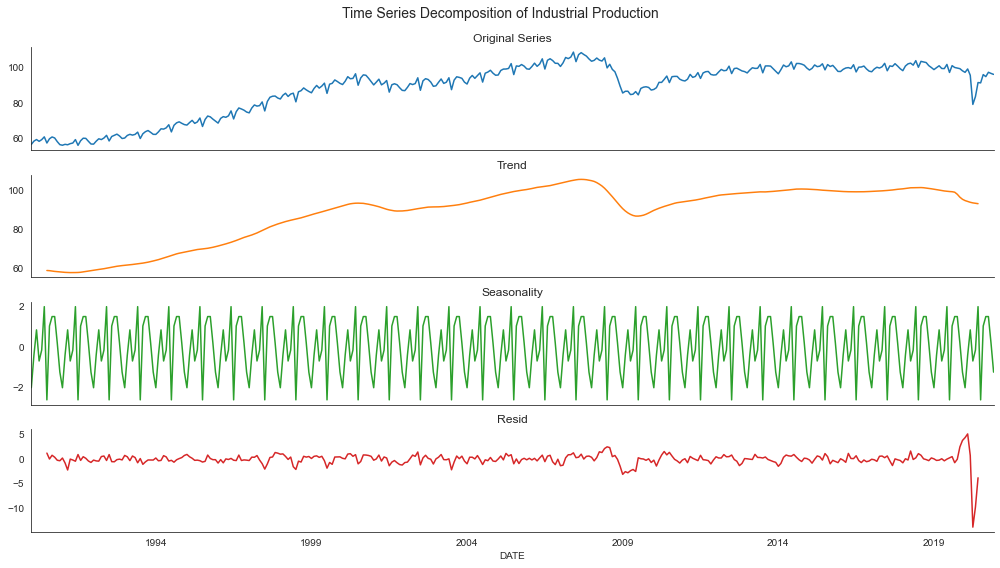

In [4]:
componentsIP = tsa.seasonal_decompose(industrial_production,model = 'additive') # another option for model is 'multiplicative'

ts = (industrial_production.to_frame('Original')
      .assign(Trend=componentsIP.trend)
      .assign(Seasonality=componentsIP.seasonal)
      .assign(Residual=componentsIP.resid))

with sns.axes_style('white'):
    ts.plot(subplots=True,figsize=(14,8),title=['Original Series','Trend','Seasonality','Resid'],legend = False)
    plt.suptitle('Time Series Decomposition of Industrial Production',fontsize = 14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

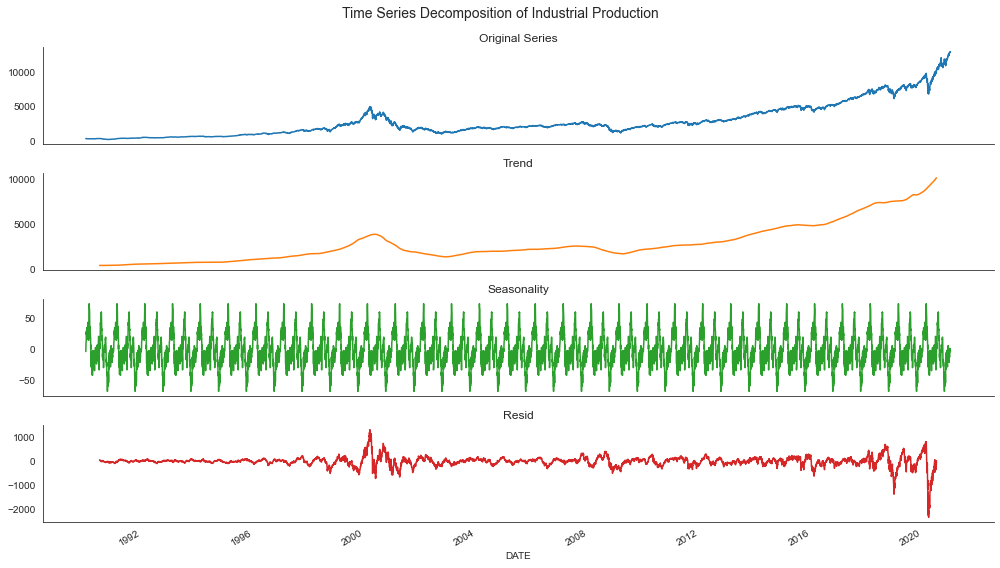

In [5]:
componentsNA = tsa.seasonal_decompose(nasdaq,model = 'additive',period=252) # another option for model is 'multiplicative'

ts = (nasdaq.to_frame('Original')
      .assign(Trend=componentsNA.trend)
      .assign(Seasonality=componentsNA.seasonal)
      .assign(Residual=componentsNA.resid))

with sns.axes_style('white'):
    ts.plot(subplots=True,figsize=(14,8),title=['Original Series','Trend','Seasonality','Resid'],legend = False)
    plt.suptitle('Time Series Decomposition of Industrial Production',fontsize = 14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

## Stationarity

The statistical properties, such as the mean, variance, or autocorrelation, of a stationary time series are independent of the period, that is, they don't change over time. Hence, stationarity implies that a time series does not have a trend or seasonal effects and that descriptive statistics, such as the mean or the standard deviation, when computed for different rolling windows, are constant or do not change much over time. It reverts to its mean, and the deviations have constant amplitude, while short-term movements always look the same in the statistical sense.

More formally, strict stationarity requires the joint distribution of any subset of time series observations to be independent of time with respect to all moments. So, in addition to the mean and variance, higher moments such as skew and kurtosis, also need to be constant, irrespective of the lag between different observations. In most applications, we limit stationarity to first and second moments so that the time series is covariance stationary with constant mean, variance, and autocorrelation.

Note that we specifically allow for dependence between observations at different lags, just like we want the input data for linear regression to be correlated with the outcome. Stationarity implies that these relationships are stable, which facilitates prediction as the model can focus on learning systematic patterns that take place within stable statistical properties. It is important because classical statistical models assume that the time series input data is stationary.

To satisfy the stationarity assumption of linear time series models, we need to transform the original time series, often in several steps. Common transformations include the application of the (natural) logarithm to convert an exponential growth pattern into a linear trend and stabilize the variance. Deflation implies dividing a time series by another series that causes trending behavior, for example dividing a nominal series by a price index to convert it into a real measure.  

In practice, time series of interest rates or asset prices are often not stationary,
for example, because there does not exist a price level to which the series reverts. The most
prominent example of a non-stationary series is the random walk for a time series of price,
pt, for a given starting price, $p_0$ (for example, a stock's IPO price) and a white-noise
disturbance, $\epsilon$, that satisfies the following:

\begin{equation}
p_t = p_{t-1} + \epsilon_t = \sum_{s=0}^t \epsilon_s + p_0
\end{equation}

If the equation includes a constant
term, then the random walk is said to have drift. Hence, the random walk is an
autoregressive stochastic process of the following form:

\begin{equation}
y_t = a_1 y_{t-1} + \epsilon_t, \textrm{} a_1 = 1
\end{equation}

The augmented Dickey-Fuller (ADF) test evaluates the null hypothesis that a time series
sample has unit root against the alternative of stationarity.

Formally, the ADF test for a time series, $y_t$, runs the linear regression:
\begin{equation}
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1}\Delta y_{t-p+1} + \epsilon_t
\end{equation}
Where $\alpha$ is a constant, $\beta$ is a coefficient on a time trend, and $p$ refers to the number of lags
used in the model. The ADF test statistics uses the sample coefficient, γ, that, under the null hypothesis of unitroot
non-stationarity equals zero, and is negative otherwise. It intends to demonstrate that,
for an integrated series, the lagged series value should not provide useful information in
predicting the first difference above and beyond lagged differences.

## Log Transformation

In [6]:
nasdaq_log = utils.log_transform(nasdaq)
industrial_production_log = utils.log_transform(industrial_production)

In [7]:
nasdaq_log,industrial_production_log

(DATE
 1990-01-02    6.129769
 1990-01-03    6.133181
 1990-01-04    6.129900
 1990-01-05    6.127349
 1990-01-08    6.128418
                 ...   
 2020-12-24    9.457570
 2020-12-28    9.464938
 2020-12-29    9.461116
 2020-12-30    9.462654
 2020-12-31    9.464074
 Name: NASDAQCOM, Length: 7813, dtype: float64,
 DATE
 1990-01-01    4.039864
 1990-02-01    4.071813
 1990-03-01    4.086648
 1990-04-01    4.069943
 1990-05-01    4.085766
                 ...   
 2020-08-01    4.563466
 2020-09-01    4.551667
 2020-10-01    4.576992
 2020-11-01    4.570435
 2020-12-01    4.564622
 Name: IPGMFN, Length: 372, dtype: float64)

## Differencing

In many cases, de-trending is not sufficient to make the series stationary. Instead, we need to transform the original data into a series of period-to-period and/or season-to-season differences. In other words, we use the result of subtracting neighboring data points or values at seasonal lags from each other. Note that when such differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns in a financial context.

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

Differencing of log series produces instantaneous returns.

In [8]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

In [9]:
nasdaq_log_diff,industrial_production_log_diff

(DATE
 1990-01-03    0.003412
 1990-01-04   -0.003282
 1990-01-05   -0.002550
 1990-01-08    0.001069
 1990-01-09   -0.004238
                 ...   
 2020-12-24    0.002629
 2020-12-28    0.007368
 2020-12-29   -0.003821
 2020-12-30    0.001538
 2020-12-31    0.001419
 Name: NASDAQCOM, Length: 7812, dtype: float64,
 DATE
 1991-01-01   -0.008248
 1991-02-01   -0.031068
 1991-03-01   -0.050311
 1991-04-01   -0.022587
 1991-05-01   -0.032256
                 ...   
 2020-08-01   -0.050928
 2020-09-01   -0.052589
 2020-10-01   -0.023676
 2020-11-01   -0.027137
 2020-12-01   -0.020759
 Name: IPGMFN, Length: 360, dtype: float64)

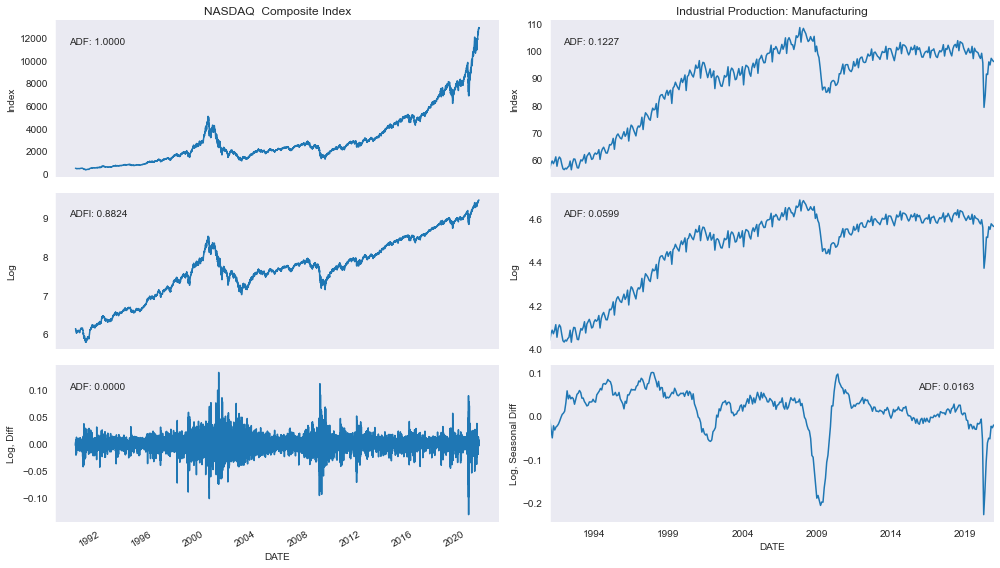

In [10]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    nasdaq.plot(ax=axes[0][0],
                title='NASDAQ  Composite Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0],
                    sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0],
                         sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                                   sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                                        sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

## Correlogram

Autocorrelation (also called serial correlation) adapts the concept of correlation to the time series context: just as the correlation coefficient measures the strength of a linear relationship between two variables, the autocorrelation coefficient, $\rho_k$, measures the extent of a linear relationship between time series values separated by a given lag, $k$.

Hence, we can calculate one autocorrelation coefficient for each of the T-1 lags in a time series; T is the length of the series. The autocorrelation function (ACF) computes the correlation coefficients as a function of the lag. The autocorrelation for a lag larger than 1 (that is, between observations more than one time step apart) reflects both the direct correlation between these observations and the indirect influence of the intervening data points. The partial autocorrelation removes this influence and only measures the linear dependence between data points at the given lag distance. The partial autocorrelation function (PACF) provides all the correlations that result once the effects of a correlation at shorter lags have been removed. A correlogram is simply a plot of the ACF or PACF for sequential lags, k=0,1,...,n.
It allows us to inspect the correlation structure across lags at one glance. The main usage of correlograms is to detect any autocorrelation after the removal of the effects of deterministic trend or seasonality. Both the ACF and the PACF are key diagnostic tools for the design of linear time series models and we will review examples of ACF and PACF plots in the following section on time series transformations.

Autocorrelation Function:
\begin{equation}
\rho_k = \frac{\sum_{t=k+1}^T (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^T(y_t - \bar{y})^2}
\end{equation}

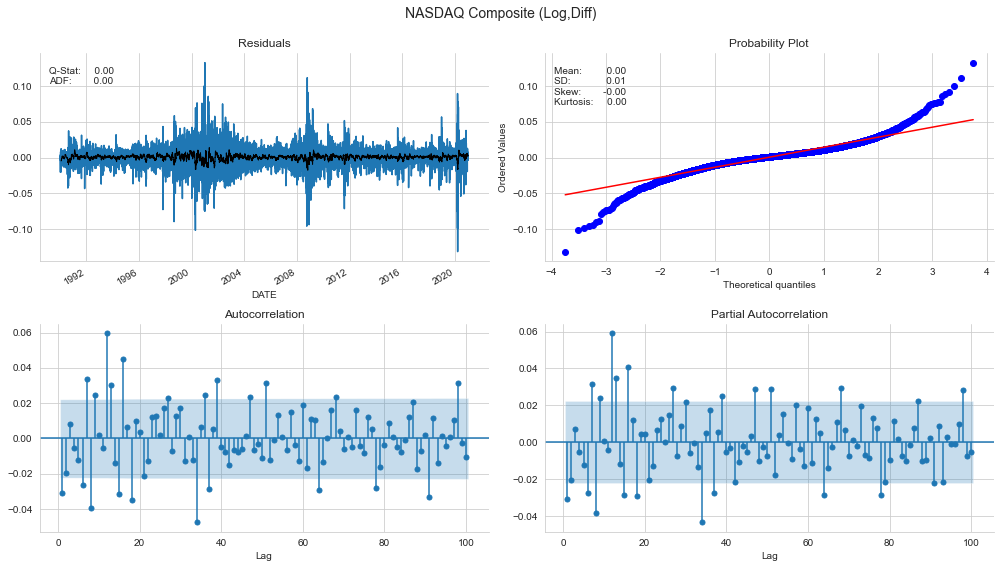

In [11]:
utils.plot_correlogram(nasdaq_log_diff, lags = 100, title='NASDAQ Composite (Log,Diff)')

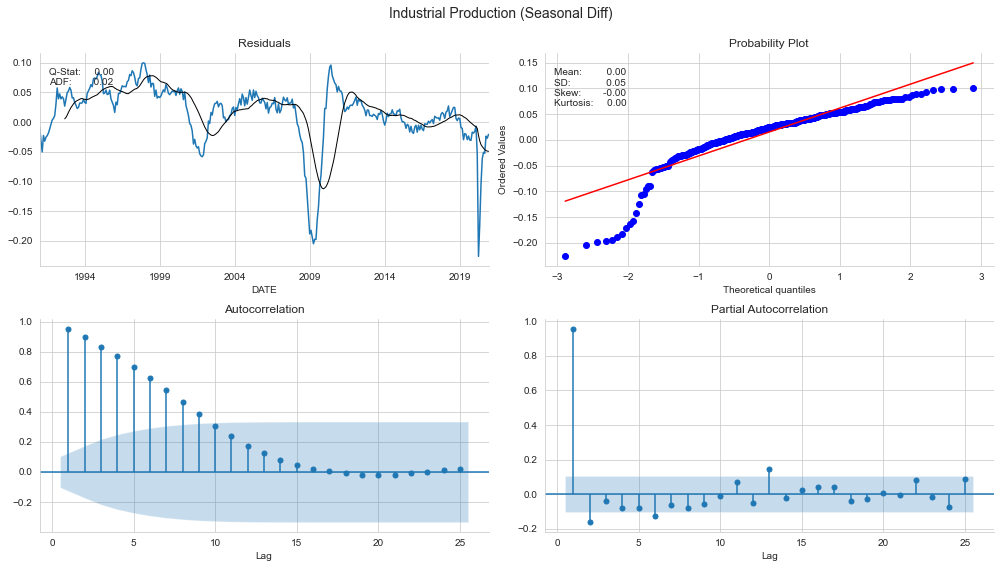

In [13]:
utils.plot_correlogram(industrial_production_log_diff,lags = 25, title='Industrial Production (Seasonal Diff)')

## Univariate Time Series Models

### Autoregressive Integrated Moving Average (ARIMA) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:

- Autoregressive (AR) terms consisting of p-lagged values of the time series
\begin{equation}
AR(p): \textrm{} \quad y_t = \phi_0 + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t, \quad \epsilon \sim i.i.d.
\end{equation}
for an AR model of order k, the ACF will show a significant serial correlation up
to lag k and, due to the inertia caused by the indirect effects of the linear relationship, will
extend to subsequent lags and eventually trail off as the effect was weakened. On the other
hand, the PACF only measures the direct linear relationship between observations a given
lag apart so that it will not reflect correlation for lags beyond k.  
In addition to inspecting the ACF to verify the absence of significant autocorrelation
coefficients, the Ljung-Box Q statistic allows us to test the hypothesis that the residual series
follows white noise. The null hypothesis is that all $m$ serial correlation coefficients are zero
against the alternative that some coefficients are not. The test statistic is computed from the
sample autocorrelation coefficients, $ρ_k$, for different lags, $k$, and follows an $\chi^2$ distribution:
\begin{equation}
Q(m) = T(T+2)\sum_{l=1}^m\frac{\rho_r^2}{T-l}
\end{equation}
- Moving average (MA) terms that contain q-lagged disturbances
\begin{equation}
MA(q): \textrm{} \quad y_t = c + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}, \quad \epsilon \sim i.i.d.
\end{equation}

The MA(q) model gets its name from representing each value of$y_t$ as a weighted moving
average of the past $q$ innovations. In other words, current estimates represent a correction
relative to past errors made by the model. The use of moving averages in MA(q) models
differs from that of exponential smoothing or the estimation of seasonal time series
components because an MA(q) model aims to forecast future values as opposed to denoising
or estimating the trend cycle of past values.

The $I$ stands for integrated because the model can account for unit-root non-stationarity by
differentiating the series d times. The term autoregression underlines that ARIMA models
imply a regression of the time series on its own values. A time series generated by an MA(q) process is driven by the residuals from the q priormodel
predictions. Hence, the ACF for the MA(q) process will show significant coefficients
for values up to the lag, q, and then decline sharply because this is how the series values are
assumed to have been generated.

An AR(p) model can be expressed as an MA(∞) process using repeated substitution. When
imposing constraints on the size of its coefficients, an MA(q) process, it becomes invertible
and can be expressed as an AR(∞) process.

Autoregressive integrated moving-average ARIMA(p, d, q) models combine AR(p) and
MA(q) processes to leverage the complementarity of these building blocks and simplify
model development by using a more compact form and reducing the number of
parameters, in turn reducing the risk of overfitting.

The models also take care of eliminating unit-root nonstationarity by using the dth
difference of the time series values. An ARIMA(p, 1, q) model is the same as using an
ARMA(p, q) model with the first differences of the series. Using $y'$ to denote the original
series after non-seasonal differencing d times, the ARIMA(p, d, q) model is simply:
\begin{equation}
ARIMA(p,d,q): \textrm{} \quad y_t = AR(p) + MA(q) = \phi_0 + \phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}, \quad \epsilon \sim i.i.d.
\end{equation}

Since AR(p) and MA(q) terms interact, the information provided by the ACF and PACF is
no longer reliable and can only be used as a starting point.
Traditionally, the AIC and BIC information criteria have been used to rely on in-sample fit
when selecting the model design. Alternatively, we can rely on out-of-sample tests to crossvalidate
multiple parameter choices.
The following summary provides some generic guidance to choose the model order in the
case of considering AR and MA models in isolation:
- The lag beyond which the PACF cuts off is the indicated number of AR terms. If
the PACF of the differenced series cuts off sharply and/or the lag-1
autocorrelation is positive, add one or more AR terms.
- The lag beyond which the ACF cuts off is the indicated number of MA terms. If
the ACF of the differenced series displays a sharp cutoff and/or the lag-1
autocorrelation is negative, consider adding an MA term to the model.
- AR and MA terms may cancel out each other's effects, so always try to reduce the
number of AR and MA terms by 1 if your model contains both to avoid
overfitting, especially if the more complex model requires more than 10 iterations
to converge.
- If the AR coefficients sum to nearly 1 and suggest a unit root in the AR part of the
model, eliminate 1 AR term and difference the model once (more).
- If the MA coefficients sum to nearly 1 and suggest a unit root in the MA part of
the model, eliminate 1 MA term and reduce the order of differencing by 1.
- Unstable long-term forecasts suggest there may be a unit root in the AR or MA
part of the model.

## ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [17]:
model1 = tsa.ARMA(endog = nasdaq_log_diff,order=(2,2)).fit()
model2 = tsa.ARMA(endog = nasdaq_log, order=(2,1,2)).fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [20]:
model1.params

const              0.000427
ar.L1.NASDAQCOM   -0.622514
ar.L2.NASDAQCOM   -0.945734
ma.L1.NASDAQCOM    0.603146
ma.L2.NASDAQCOM    0.930497
dtype: float64

In [21]:
model2.params

const              7.780023
ar.L1.NASDAQCOM    1.432153
ar.L2.NASDAQCOM   -0.432177
ma.L1.NASDAQCOM   -0.462912
dtype: float64